# Simplified Diffusion Model
**Remember to enable GPU**

This notebook demonstrates how to implement and train a simple diffusion model to generate images of aquariun fish. The model is kept simple for teaching purposes.

For an implementation that is closer to the original, you are referred to [this tutorial](https://keras.io/examples/generative/ddpm/).

## Your task
Your task is simply to see if you can match the code against the theory presented in the slides of Lecture 13. Focus on understanding
- the noise scheduler (i.e., how $\beta_t$ changes over time)
- the forward diffusion process
- the U-net architecture, in particular the temporal embeddings
- the reverse diffusion process (also called sampling)

In [ ]:
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

## 1. Download data
We will be using the "aquariun fish" images of the CIFAR101 dataset.

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')
X_train = X_train[y_train.squeeze() == 1] # restrict class label to "aquarium_fish" (full class list here: https://github.com/MartinThoma/algorithms/blob/master/ML/confusion-matrix/labels/cifar-100-labels.json)
X_train = (X_train / 127.5) - 1.0

In [ ]:
IMG_SIZE = 32     # img_size CIFAR-10 img_size is 32x32 and therefore input img size is 32
BATCH_SIZE = 8  # batch size

In [ ]:
# Restrict to the first 8 samples
# This is purely for speeding up the lab runtime, the model will heavily overfit!
X_train = X_train[:BATCH_SIZE]

## 2. Utility functions

In [110]:
from pickle import NONE

def cvtImg(img):
    # Normalize image intensities
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

def show_examples(x,t=None):
    # Show multiple images
    plt.figure(figsize=(10, 5))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        if t is not None:
          plt.title(f"t={t[i]}")
        plt.axis('off')

## 3. Noise schedule
Recall that in the forward diffusion process, the noise-level is controlled by $\beta_t$ ($0<\beta_1<\beta_2<...<\beta_T<1$), which increases gradually over time according to some schedule. Here, we are using a linear schedule of 8 timesteps.

In [111]:
n_timesteps = 8    # number of time steps in the diffusion process (corresponds to T in the slides of lecture 13)
betas = np.linspace(0, 1.0, n_timesteps + 1) # noise variance schedule for adding noise to the image

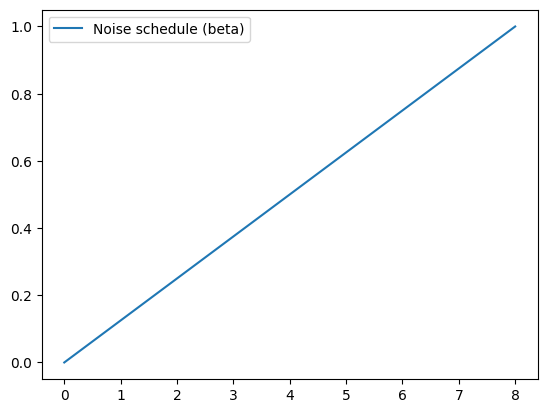

In [112]:
plt.plot(betas, label='Noise schedule (beta)')
_ = plt.legend()

## 4. Forward diffusion
Due to the way the training loop works, we will define a function that generates two consecutive images for time $t$ and time $t+1$. Both images are based on the same base image ($x_0$) and the same random noise:
- The image at time $t$ has more weight on $x_0$ and a lower loise level (according to the noise schedule).
- The image at time $t+1$ has less weight on $x_0$ and a higher loise level


In [113]:
def forward_noise(x_0, t, betas):
    # Function used for forward diffusion
    a = betas[t]      # noise level for t
    b = betas[t + 1]  # noise level for t + 1 (higher)

    noise = np.random.normal(size=x_0.shape)  # random noise

    # Generate the two images
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x_0 * (1 - a) + noise * a # image at time t
    img_b = x_0 * (1 - b) + noise * b # image at time t+1

    return img_a, img_b

### 3.1 Example of forward diffusion process
Here, we are using the same base image to generate images at all time steps of the forward diffusion process. Note that the noise level iz determined by $t$ according to the noise schedule (`betas`).

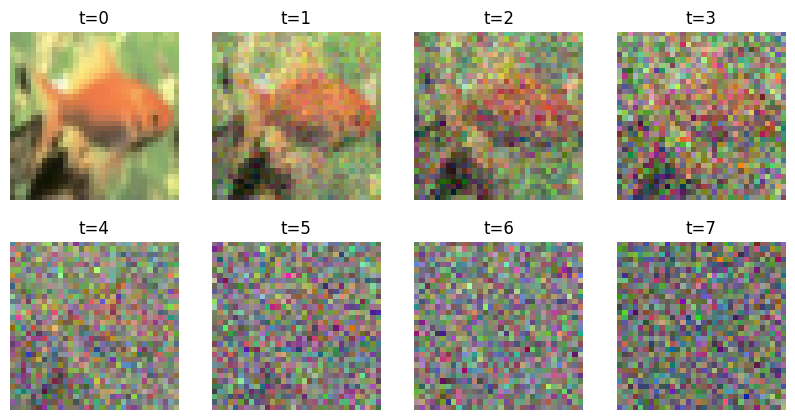

In [114]:
t = np.array(list(range(n_timesteps))) # all time steps
image_index = 2 # selected base image
indices = [image_index for i in range(n_timesteps)] # hack to select the same image for each time step
a, b = forward_noise(X_train[indices], t,betas)
show_examples(a,t)

### 3.1 Generating a training batch
Let's consider the first 8 training images.

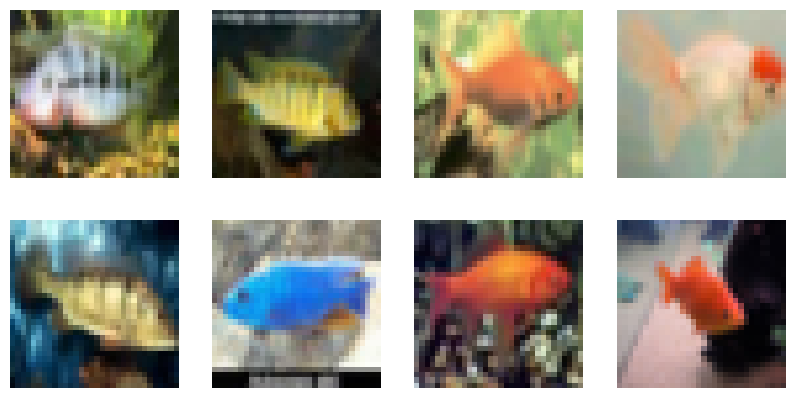

In [115]:
show_examples(X_train[:8])

Next, let us generate some training pairs for these 8 images. For each image, we will select `t` at random.

In [ ]:
def generate_ts(num):
    return np.random.randint(0, n_timesteps, size=num)

# Random choices of t
t = generate_ts(8)

# Training pairs
a, b = forward_noise(X_train[:8], t, betas)

Show images at time `t` (less noise):

In [ ]:
show_examples(a,t)

Show images at time `t+1` (more noise):

In [ ]:
show_examples(b,t)

## 4. U-net architecture
We will now implement the U-net architecture. Recall that this is a special variant of the U-net that also takes time `t` as input. This is done using learnable time embeddings, that are added to each layer of the U-net.

In [ ]:
# Basic U-net block
def block(x_img, x_ts, n_filters=32):
    # Convolution
    img_embedding = layers.Conv2D(n_filters, kernel_size=3, padding='same')(x_img)
    img_embedding = layers.Activation('relu')(img_embedding)

    # Time embedding
    time_embedding = layers.Dense(n_filters)(x_ts)
    time_embedding = layers.Activation('relu')(time_embedding)
    time_embedding = layers.Reshape((1, 1, n_filters))(time_embedding)

    # Combine embeddings
    combi_embedding = img_embedding * time_embedding

    # Final embedding
    embedding = layers.Conv2D(n_filters, kernel_size=3, padding='same')(x_img)
    embedding = embedding + combi_embedding
    embedding = layers.LayerNormalization()(embedding)
    embedding = layers.Activation('relu')(embedding)

    return embedding

In [ ]:
def build_unet():

    # Image
    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')

    # Time step (t)
    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(32)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)

    # ----- left ( downsampling part of U-net ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x4 = block(x, x_ts)

    # ----- MLP (U-net bottleneck) -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(64)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    # ----- right ( upsampling part of U-net ) -----
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)

    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

model = build_unet()
model.summary()

### 4.1 Test by running inference using the *untrained* U-net
To generate an image, we need to run the *reverse diffusion* process. This process starts with an image that is just random noise, and then iteratively denoises the image for time going from $T$ to $0$.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)

In [ ]:
# This illustrates the reverse diffusion process for a single image
# (every other time step)
def reverse_diffusion_steps(x_idx=None): # untrianed model output
    xs = [] # store all images from reverse diffusion here

    # input is just random noise
    x = np.random.normal(size=(1, IMG_SIZE, IMG_SIZE, 3))

    for t in reversed(range(n_timesteps)):
        x = model.predict([x, np.full((1), t)], verbose=0)
        if t % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

reverse_diffusion_steps()

In [ ]:
# This generates a batch of 16 images, each with a different starting point (random noise)
def reverse_diffusion_batch(x_idx=None): # untrianed model output
    all_x = [] # store all images from reverse diffusion here

    # input is just random noise
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    for t in reversed(range(n_timesteps)):
        x = model.predict([x, np.full((8), t)], verbose=0)

    show_examples(x)

reverse_diffusion_batch()

## 5. Model training
Don't expect impressive results with this simple implementation.

But notice how the images become more and more fish-like, as the model trains :-)

In [ ]:
R=50
for i in range(10):
    bar = trange(R)
    total = 2
    for i in bar:
        for j in range(total):
            x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
            x_ts = generate_ts(len(x_img)) # assign random time t to each image in the batch
            x_a, x_b = forward_noise(x_img, x_ts, betas) # forward diffusion
            with tf.GradientTape() as tape:
              x_a_pred = model([x_b, x_ts], training=True) # predict x_a from x_b (and time t)
              loss = loss_func(x_a, x_a_pred)
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            pg = (j / total) * 100
        bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.99)

    # show test result
    reverse_diffusion_steps()
    reverse_diffusion_batch()
    plt.show()